In [3]:
#@title Installs and Imports
!pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import functools

import jax
import jax.numpy as jnp

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/instadeepai/QDax@2-instadeep-new-structure-suggestion |tail -n 1
    import qdax

from qdax.algorithms.map_elites import MAPElites, compute_cvt_centroids
from qdax import brax_envs
from qdax.utils.mdp_utils import scoring_function
from qdax.buffers.buffers import QDTransition
from qdax.networks.flax_networks import MLP
from qdax.emitters.mutation_operators import isoline_crossover_function
from qdax.emitters.standard_emitters import MixingEmitter
from qdax.analysis.plotting import plot_2d_map_elites_grid



if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()


clear_output()

In [4]:
#@title QD Training Definitions Fields
#@markdown ---
batch_size = 1024 #@param {type:"number"}
env_name = 'ant_omni'#@param['ant', 'hopper', 'walker', 'halfcheetah', 'humanoid', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_iterations = 100 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = [64, 64] #@param {type:"raw"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 10000 #@param {type:"integer"}
min_bd = -15.0 #@param {type:"number"}
max_bd = 15.0 #@param {type:"number"}
#@markdown ---

In [5]:
# Init environment
env = brax_envs.create(env_name)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + [env.action_size]
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    kernel_init_final=jax.nn.initializers.uniform(1e-3),
    final_activation=jnp.tanh,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)


# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

In [6]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
  """
  Play an environment step and return the updated state and the transition.
  """

  actions = policy_network.apply(policy_params, env_state.obs)
  next_state = env.step(env_state, actions)

  transition = QDTransition(
      obs=env_state.obs,
      next_obs=next_state.obs,
      rewards=next_state.reward,
      dones=next_state.done,
      actions=actions,
      truncations=next_state.info["truncation"],
      state_desc=env_state.info["state_descriptor"],
      next_state_desc=next_state.info["state_descriptor"],
  )

  return next_state, policy_params, random_key, transition

In [7]:
# Prepare the scoring function
random_key, subkey = jax.random.split(random_key)
bd_extraction_fn = brax_envs.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    random_key=random_key,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Define emitter
crossover_fn = functools.partial(
    isoline_crossover_function, iso_sigma=0.05, line_sigma=0.1
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    crossover_fn=crossover_fn, 
    crossover_percentage=1.0, 
    batch_size=batch_size
)

# Define emitter functions
emit_fn = mixing_emitter.emit_fn
emitter_state_update_fn = mixing_emitter.state_update_fn

# Get minimum reward value to make sure qd_score are positive
reward_offset = brax_envs.reward_offset[env_name]

# Define a metrics function
def metrics_fn(repertoire):

    # Get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    qd_score = jnp.sum(repertoire.fitnesses, where=~grid_empty)
    # Add offset for positive qd_score
    qd_score += reward_offset * episode_length * jnp.sum(1.0 - grid_empty)
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(repertoire.fitnesses)

    return {
        "qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage
    }

In [8]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emit_fn=emit_fn,
    emitter_state_update_fn=emitter_state_update_fn,
    metrics_function=metrics_fn,
    discard_dead=False,
)

# Compute the centroids
centroids = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
)

# Compute initial repertoire
repertoire, _ = map_elites.init_fn(init_variables, centroids, None)

In [9]:
# Prepare scan over map_elites update to perform several iterations at a time
@jax.jit
def update_scan_fn(carry, unused):
    # iterate over grid
    repertoire, random_key = carry
    (repertoire, _, metrics, random_key,) = map_elites.update_fn(
        repertoire,
        None,
        random_key,
    )

    return (repertoire, random_key), metrics

In [10]:
# Run the algorithm
(repertoire, random_key,), metrics = jax.lax.scan(
    update_scan_fn,
    (repertoire, random_key),
    (),
    length=num_iterations,
)

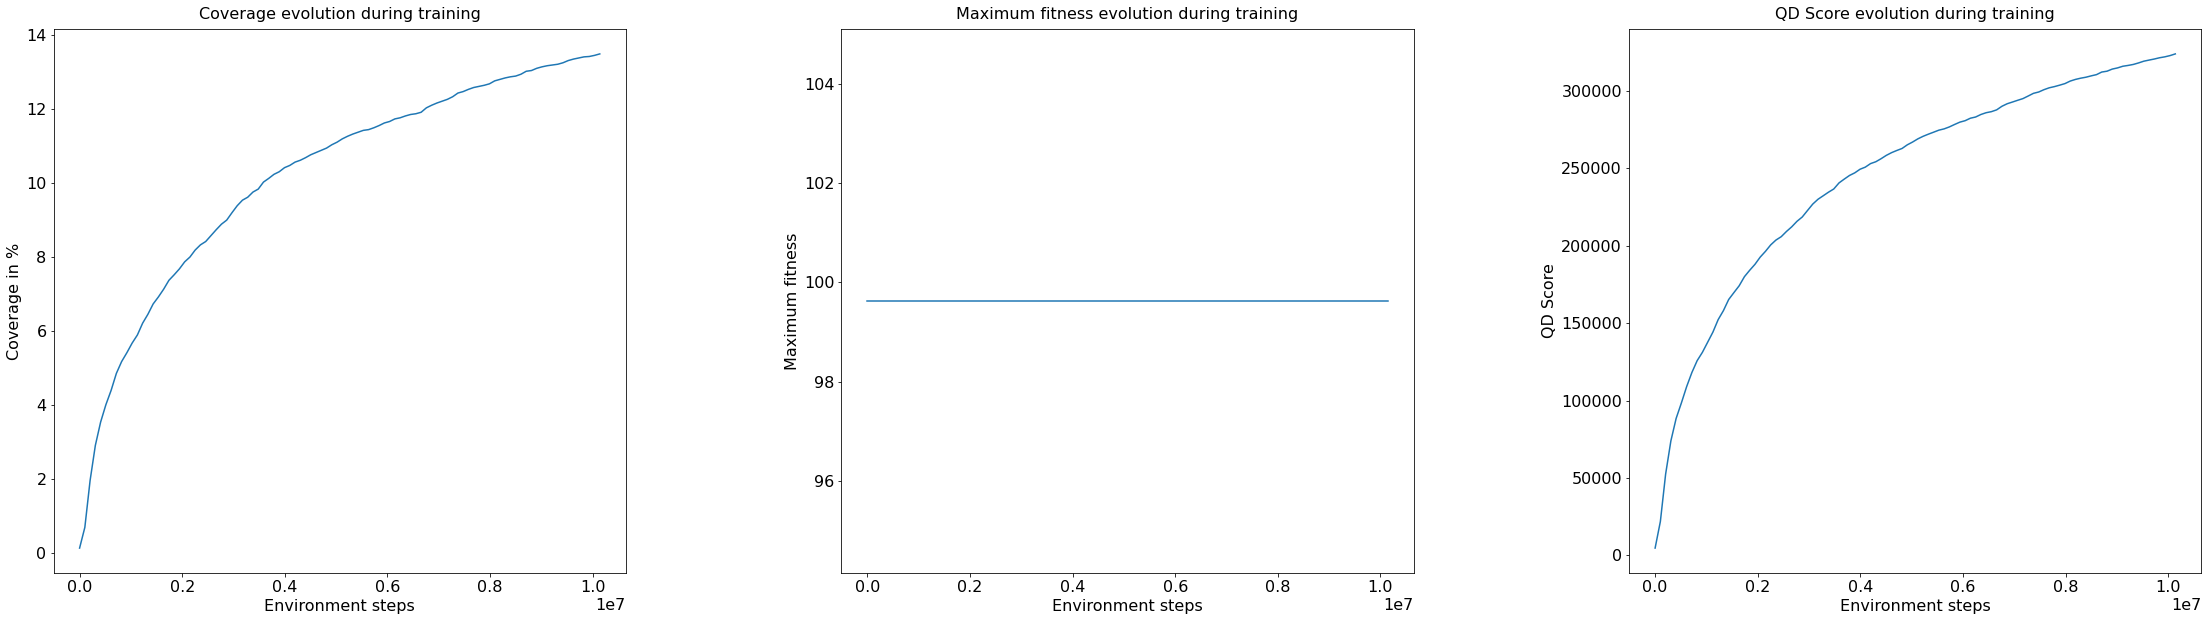

In [ ]:
#@title Visualization

# Customize matplotlib params
font_size = 16
params = {
    "axes.labelsize": font_size,
    "axes.titlesize": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "text.usetex": False,
    "axes.titlepad": 10,
}

mpl.rcParams.update(params)

# Visualize the training evolution and final repertoire
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40,10))

env_steps = jnp.arange(num_iterations) * episode_length * batch_size

axes[0].plot(env_steps, metrics['coverage'])
axes[0].set_xlabel('Environment steps')
axes[0].set_ylabel('Coverage in %')
axes[0].set_title('Coverage evolution during training')
axes[0].set_aspect(0.95/axes[0].get_data_ratio(), adjustable='box')

axes[1].plot(env_steps, metrics['max_fitness'])
axes[1].set_xlabel('Environment steps')
axes[1].set_ylabel('Maximum fitness')
axes[1].set_title('Maximum fitness evolution during training')
axes[1].set_aspect(0.95/axes[1].get_data_ratio(), adjustable='box')

axes[2].plot(env_steps, metrics['qd_score'])
axes[2].set_xlabel('Environment steps')
axes[2].set_ylabel('QD Score')
axes[2].set_title('QD Score evolution during training')
axes[2].set_aspect(0.95/axes[2].get_data_ratio(), adjustable='box')

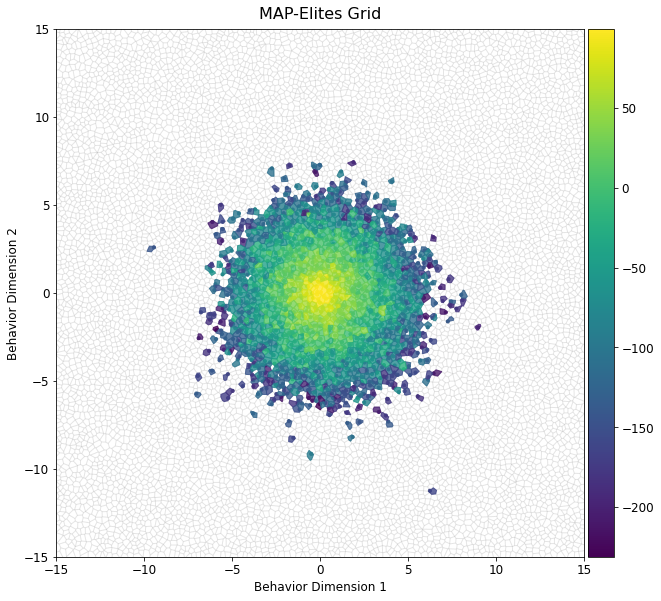

In [13]:
fig, ax = plot_2d_map_elites_grid(
    centroids=centroids,
    grid_fitness=repertoire.fitnesses,
    minval=min_bd,
    maxval=max_bd,
    grid_descriptors=repertoire.descriptors,
    ax=None,
)
plt.show()